# Bayesian Convolutional Neural Network

베이지안 신경망(Bayesian Neural Networks, BNN)은 신경망의 가중치(weight)와 편향(bias)을 확률 분포로 표현하는 신경망 모델입니다. 기존의 신경망 모델은 가중치와 편향을 어떤 고정된 값으로 가정하고 학습합니다. 이 때문에 학습 데이터에 잘 맞는 모델을 만들 수는 있지만, 새로운 데이터에 대해서는 일반화하지 못하는 과적합(overfitting)의 문제가 발생할 수 있습니다. 이러한 경향은 특히 새로운 테스트 데이터에 노이즈가 많은 경우 더욱 두드러집니다.

반면, 베이지안 관점에서 모델이 학습하는 가중치와 편향은 그 자체로 불확실성을 내포하는 확률 변수로 취급됩니다. 모델은 각 매개 변수에 대한 사전 확률 분포를 정의한 후, 훈련 데이터를 사용하여 각 매개변수의 사후 확률 분포를 도출합니다. 

기존의 인공 신경망 모델과 비교했을 때, 베이지안 신경망은 다음과 같은 두 가지 장점을 가집니다.

 1. **과적합 방지**: 베이지안 신경망은 개별 데이터 포인트에 대한 예측값들의 분포 구간을 통해 모델의 복잡도를 제어하고 과적합을 방지할 수 있습니다.
 
 2. **모델의 불확실성 측정**: 베이지안 신경망은 엔트로피의 형태로 모델의 예측이 갖는 불확실성을 명시적으로 측정할 수 있습니다.

베이지안 신경망은 아직까지 연구 초기 단계에 있는 기술이지만, 머신러닝 분야에서 기존의 문제점들을 해결할 수 있는 새로운 가능성으로 주목받고 있습니다. 특히, 의료 영상 분석, 자연어 처리 및 추천 시스템 등에서 기존의 신경망 모델보다 우수한 성능을 보입니다.

이 프로젝트에서는 MNIST와 Corrupted MNIST를 통해 베이지안 CNN과 기존의 CNN 모델을 비교해 보겠습니다. [MNIST](http://yann.lecun.com/exdb/mnist/)는 0부터 9까지의 숫자를 손글씨로 쓴 28x28 픽셀의 흑백 이미지로 이루어져 있고, 각 이미지는 해당하는 숫자의 레이블을 가지고 있습니다. [Corrupted MNIST](https://zenodo.org/records/3239543)는 MNIST 데이터셋에 인위적으로 노이즈를 가한 버전입니다. 이렇게 만들어진 손상된 데이터셋은 모델이 노이즈에 강건하게 대응하고 일반화하는 능력이 있는지 평가하는 벤치마크로 사용됩니다. 

In [24]:
# Import packages

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [25]:
print('TensorFlow Version:', tf.__version__)
print('TensorFlow Probability Version:', tfp.__version__)

TensorFlow Version: 2.14.0
TensorFlow Probability Version: 0.22.1


### Load Data

In [3]:
# Function to load training and test data, with labels in integer and one-hot form

def load_data(name):
    data_dir = os.path.join('data', name)

    # Get train data
    X_train = 1 - np.load(os.path.join(data_dir, 'train_images.npy')) / 255.
    X_train = X_train.astype(np.float32)

    y_train = np.load(os.path.join(data_dir, 'train_labels.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)

    # Get test data
    X_test = 1 - np.load(os.path.join(data_dir, 'test_images.npy')) / 255.
    X_test = X_test.astype(np.float32)
    y_test = np.load(os.path.join(data_dir, 'test_labels.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)

    return (X_train, y_train, y_train_oh), (X_test, y_test, y_test_oh)

In [4]:
# Function to inspect dataset digits

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

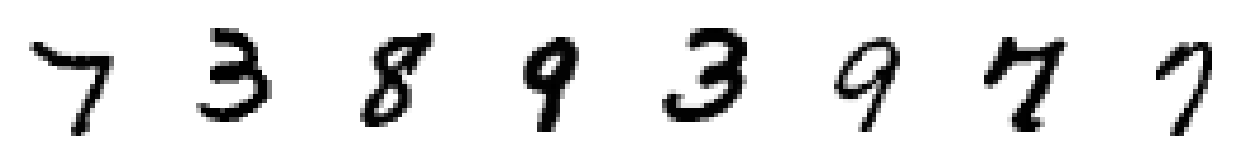

In [5]:
# Load and inspect the MNIST dataset

(x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh) = load_data('mnist')
inspect_images(data=x_train, num_images=8)

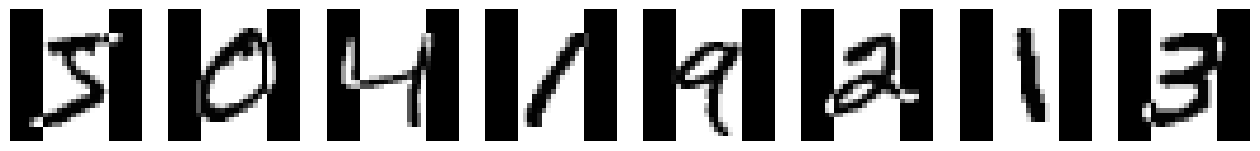

In [6]:
# Load and inspect the MNIST-C dataset

(x_c_train, y_c_train, y_c_train_oh), (x_c_test, y_c_test, y_c_test_oh) = load_data('mnist_c/stripe')
inspect_images(data=x_c_train, num_images=8)

## Deterministic CNN Model

베이지안 신경망을 구현하기에 앞서 MNIST 데이터를 활용해 간단한 형태의 CNN 모델을 만들고 Corrupted MNIST 데이터에 대한 예측 성능을 평가해 보겠습니다. 모델의 아키텍처는 다음과 같습니다.

 * 첫 번째 레이어는 8개의 필터, 5x5 커널, ReLU 활성화 함수 및 'VALID' 패딩을 가진 Conv2D 레이어입니다.
 * 두 번째 레이어는 6x6 윈도우 크기의 MaxPooling2D 레이어입니다.
 * 세 번째 레이어는 Flatten 레이어 입니다.
 * 마지막으로 10개의 학습 레이블을 예측할 수 있는 Dense 레이어를 출력 레이어로 갖습니다. 클래스 예측을 위해 softmax 활성화 함수를 적용합니다.

In [7]:
def get_deterministic_model(input_shape, loss, optimizer, metrics):
    """
    This function builds and compiles a CNN model according to the specifications given by the arguments. 

    Args:
        input_shape (tuple): The shape of the input data.
        loss (str): The loss function to be used during training.
        optimizer (str): The optimizer to be used during training.
        metrics (list): The metrics to be evaluated during training and testing.

    Returns:
        model (tf.keras.Model): The compiled CNN model.
    """

    model = tf.keras.Sequential([
        Conv2D(8, (5, 5), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D((6, 6)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [8]:
tf.random.set_seed(1123)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28, 1),
    loss=SparseCategoricalCrossentropy(),
    optimizer=RMSprop(),
    metrics=['accuracy']
)

In [9]:
# Print the model summary
print(deterministic_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 8)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 1498 (5.85 KB)
Trainable params: 1498 (5.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [10]:
# Train the model
deterministic_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.5851 - accuracy: 0.8399
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1817 - accuracy: 0.9459
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1438 - accuracy: 0.9558
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1259 - accuracy: 0.9608
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1149 - accuracy: 0.9637


In [11]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(deterministic_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(deterministic_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9643999934196472
Accuracy on corrupted MNIST test set:  0.5419999957084656


예상대로, Corrupted MNIST 데이터에 대한 Deterministic CNN 모델의 예측성능은 MNIST 데이터에 비해 상대적으로 낮습니다. 이는 모델이 학습한 파라미터 값이 손상되지 않은 MNIST 데이터로만 훈련된 상수이기 때문입니다. 따라서 모델은 새로운 데이터가 가질 수 있는 불확실성을 반영하고 있지 않습니다. 

한편, Corrupted MNIST 데이터에는 학습 데이터에서 볼 수 없었던 노이즈가 많이 포함되어 있어 모델이 이러한 노이즈에 적응하지 못하고 예측 성능이 저하됩니다.

## Bayesian CNN Model

다음으로 동일한 데이터를 사용하여 베이지안 CNN 모형을 만들고 Corrupted MNIST 데이터에서의 예측 성능을 평가해 보겠습니다.

먼저, 아래와 같이 negative loglikelihood 손실 함수를 정의합니다. 이 함수는 올바른 레이블에 대한 인수 `y_true`(원-핫 벡터)와 모델 예측에 대한 인수 `y_pred`(One Hot Categorical 분포)를 갖습니다. 예측된 분포 `y_pred`가 주어졌을 때 `y_true`의 각 샘플에 대한 negative loglikelihood를 반환합니다. `y_true`의 형태가 `[B,E]`이고 `y_pred`의 Batch 형태가 `[B]`, 이벤트 형태가 `[E]`라고 할 때, 출력은 `[B]`형태의 텐서 입니다.

In [26]:
def nll(y_true, y_pred):
    """
    Calculate the negative log-likelihood of each sample in y_true given the predicted distribution y_pred.

    Args:
        y_true (Tensor): The true values of the target variable. Shape [B, E].
        y_pred (Tensor): The predicted distribution of the target variable. Batch shape [B] and event shape [E].

    Returns:
        Tensor: The negative log-likelihood of each sample in y_true. Shape [B].
    """
    
    return -y_pred.log_prob(y_true)

다음으로 사전 확률과 사후 확률 분포에 사용될 "Spike-and-slab" 분포를 생성하는 함수를 정의하겠습니다. Spike-and-slab 분포는 spike와 slab의 혼합 분포로서, 특정 값들을 정확하게(precision) 모델링하는 spike와 확실하게(confidence) 모델링하는 slab으로 구성 됩니다. 이는 변수선택이나 일부 파라미터에 대한 불확실성을 효과적으로 다룰 때 유용합니다.

 * **`event_shape`**: 분포의 이벤트 형태를 나타내는 값으로, 주로 모델링하려는 변수의 차원과 관련이 있습니다.
 * **`dtype`**: 데이터 타입으로, 분포에서 사용되는 값들의 자료형을 지정합니다.
 * **`tfp.distributions.Dristribution`**: 생성된 spike-and-slab 분포의 인스턴스를 반환합니다. Spike는 평균이 0이고 표준편차가 1.0인 정규분포이며, Slab은 평균이 0이고 표준편차가 10.0인 정규분포입니다. 두 구성 요소가 혼합되어 spike-and-slab 분포를 형성하며, 각 구성 요소의 선택확률은 0.5로 설정되어 있습니다.

In [27]:
def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

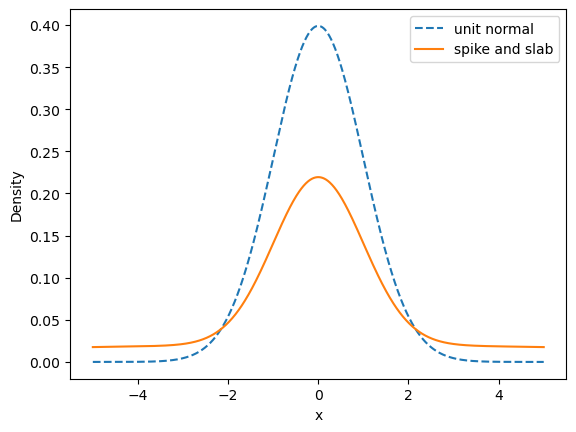

In [28]:
# Plot the spike and slab distribution pdf

x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

이어서 앞서 설명한 "spike-and-slab" 분포를 사용하여 파라미터의 사전 확률 분포와 사후 확률 분포를 생성하겠습니다. 

In [29]:
def get_prior(kernel_size, bias_size, dtype=None):
    """
    Create the prior distribution using a "spike-and-slab" distribution.

    Args:
    - kernel_size: Size of the kernel in the model.
    - bias_size: Size of the bias in the model.
    - dtype: Data type specifying the type of values used in the distribution.

    Returns:
    tf.keras.Sequential: A callable that returns the prior distribution.
    """
        
    n = kernel_size + bias_size
    prior = Sequential([
        tfpl.DistributionLambda(
            lambda t: spike_and_slab(n, dtype)
        )
    ])
    
    return prior

In [30]:
def get_posterior(kernel_size, bias_size, dtype=None):
    """
    Create the posterior distribution as specified above.

    Args:
    - kernel_size: Size of the kernel in the model.
    - bias_size: Size of the bias in the model.
    - dtype: Data type specifying the type of values used in the distribution.

    Returns:
    tf.keras.Sequential: A callable that returns the posterior distribution.
    """
    
    n = kernel_size + bias_size
    posterior = Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype),
        tfpl.IndependentNormal(n)
    ])
    
    return posterior

다음으로 Convolutional2DReparameterization 레이어 인스턴스를 생성하기 위한 함수를 정의하겠습니다.

Convolutional2DReparameterization 레이어는 기존의 Conv2D 레이어와 다음과 같은 주요한 차이점이 있습니다.

 1. 확률적인 측면:
    * Conv2D 레이어: 이 레이어는 결정론적인(deterministic) 방식으로 동작하며 가중치와 편향은 고정된 값으로 학습됩니다. 따라서 동일한 입력에 대한 레이어의 출력은 항상 같습니다.
    * Convolution2DReparameterization 레이어: 이 레이어는 확률적인 방식으로 동작합니다. 가중치와 편향은 훈련 과정에서 업데이트 되는 확률 분포를 따릅니다. 따라서 동일한 입력에 대한 레이어의 출력은 확률 분포에 의해 결정 됩니다. 이로써 모델의 불확실성을 캡처할 수 있습니다.
 2. 변분 추론과 발산 함수:
    * Conv2D 레이어: 일반적인 인공 신경망에서는 변분 추론을 사용하지 않습니다. 가중치와 편향은 역전파를 사용하여 최적화 됩니다.
    * Convolutional2DReparameterization 레이어: 변분 추론을 사용하여 가중치 및 편향의 사후 분포를 근사화합니다. `divergence_fn` 매개변수를 통해 발산 함수를 지정하여 사후 분포와 사전 분포 간의 차이를 측정합니다.


In [ ]:
def get_convolutional_reparameterization_layer(input_shape, divergence_fn):
    """
    Create an instance of a Convolution2DReparameterization layer.

    Args:
    - input_shape (tuple): Shape of the input data.
    - divergence_fn (function): Divergence function for variational inference.

    Returns:
    tfpl.Convolution2DReparameterization: Instance of the convolutional reparameterization layer.
    """
        
    layer = tfpl.Convolution2DReparameterization(
        8, (5, 5), padding='valid',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(),
        bias_divergence_fn=divergence_fn,
        activation='relu',
        input_shape=input_shape
    )
    return layer

다음으로 DenseVariational 레이어를 아래의 함수를 통해 정의하겠습니다. DenseVariational 레이어는 기존의 Dense 레이어와는 다르게 확률적인 측면을 고려한 변분 레이어입니다. Dense 레이어와의 주요 차이점은 다음과 같습니다:

 1. 확률적 모델링:
    * Dense 레이어: 기존의 Dense 레이어는 확률적이 아닌 결정론적인 모델을 나타냅니다. 즉, 동일한 입력에 대해 항상 동일한 출력을 생성합니다.
    * DenseVariational 레이어: 확률적 프로그래밍 개념을 도입하여, 모델의 매개변수가 확률 분포를 따르게 됩니다. 이는 모델의 불확실성과 예측값의 불확실성을 고려할 수 있게 합니다.
 2. 사전 분포와 사후 분포:
    * Dense 레이어: 사전 분포나 사후 분포를 고려하지 않습니다. 즉, 모델의 가중치 추정값이 학습 과정에서 변한다고 해도, 그 값은 상수로서 어떠한 확률적인 의미도 없습니다.
    * DenseVariational 레이어: `prior_fn`과 `posterior_fn`을 사용하여 사전 분포와 사후 분포를 정의합니다. 이를 통해 가중치의 불확실성을 고려하며 훈련중에 이 불확실성을 업데이트 합니다.
 3. KL 발산 손실:
    * Dense 레이어: KL 발산 손실이 존재하지 않습니다. 즉, 모델의 확률 분포 간의 차이를 고려하지 않습니다.
    * DenseVariational 레이어: KL 발산 손실이 포함되어 있습니다. 이것은 훈련 중에 모델의 사후 분포가 사전 분포와 얼마나 다른지를 측정하는 데 사용되며, 모델의 불확실성을 제어하는 데 중요한 역할을 합니다.
 4. 불확실성의 측정:
    * Dense 레이어: 모델의 예측은 결정론적이며 불확실성을 고려하지 않습니다.
    * DenseVariational 레이어: 모델의 예측은 확률적이며, 예측의 불확실성을 고려할 수 있습니다. 이는 예측 구간(prediction interval) 등을 계산할 때 유용합니다.

In [31]:
def get_dense_variational_layer(prior_fn, posterior_fn, kl_weight):
    """
    Create an instance of a DenseVariational layer according to the given specification.
    
    Args:
        prior_fn: A function that defines the prior distribution for the layer.
        posterior_fn: A function that defines the posterior distribution for the layer.
        kl_weight: The weight for the Kullback-Leibler (KL) divergence loss term.
        
    Returns:
        A DenseVariational layer instance.
    """
    
    n_classes = 10
    layer = tfpl.DenseVariational(
        tfpl.OneHotCategorical.params_size(n_classes),
        make_posterior_fn=posterior_fn,
        make_prior_fn=prior_fn,
        kl_weight=kl_weight,
        kl_use_exact=False
    )
    
    return layer

다음으로 베이지안 CNN 모형의 인스턴스를 생성 하겠습니다. 모델은 다음과 같은 레이어 아키텍쳐를 같습니다.

 * Convolution2DReparameterization
 * Max Pooling
 * Flatten
 * DenseVariational
 * OneHotCategorical

마지막의 OneHotCategorical는 TensorFlow Probability에서 제공하는 레이어로 범주형 데이터를 다루기 위한 확률 레이어 입니다. 이 레이어는 주로 다준 클래스 분류 문제에서 각 클래스에 대한 확률을 나타내는 One-Hot 벡터를 생성하여 출력 확률 분포를 모델링하고, 이에 기반하여 샘플링을 수행하는 데 사용됩니다. 

In [32]:
tf.random.set_seed(1123)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / x_train.shape[0]
convolutional_reparameterization_layer = get_convolutional_reparameterization_layer(
    input_shape=(28, 28, 1), divergence_fn=divergence_fn
)
dense_variational_layer = get_dense_variational_layer(
    get_prior, get_posterior, kl_weight=1/x_train.shape[0]
)

In [33]:
bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])
bayesian_model.compile(loss=nll,
              optimizer=RMSprop(),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

생성된 베이지안 CNN 모델의 구조는 다음과 같습니다.

In [34]:
# Print the model summary

bayesian_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_  (None, 24, 24, 8)         416       
 1 (Conv2DReparameterizatio                                      
 n)                                                              
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 8)           0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_variational_1 (Dense  (None, 10)                2580      
 Variational)                                                    
                                                                 
 one_hot_categorical_1 (One  ((None, 10),             

In [35]:
# Train the model

bayesian_model.fit(x=x_train, y=y_train_oh, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 2.0101 - accuracy: 0.3217
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.7483 - accuracy: 0.7612
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4011 - accuracy: 0.8800
Epoch 4/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2856 - accuracy: 0.9178
Epoch 5/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2330 - accuracy: 0.9357


In [23]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(bayesian_model.evaluate(x_test, y_test_oh, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(bayesian_model.evaluate(x_c_test, y_c_test_oh, verbose=False)[1]))

Accuracy on MNIST test set:  0.9452999830245972
Accuracy on corrupted MNIST test set:  0.6805999875068665


베이지안 CNN 모델을 사용하였을 때, Corrupted MNIST 데이터셋에 대한 예측 성능이 약 54%에서 68%로 개선되었음을 알 수 있습니다.

## Exploratory Data Analysis

아래의 함수는 주어진 이미지에 대한 모델의 예측을 시각화하는 함수입니다. 파라미터는 아래와 같습니다.

 * **`data`**: 이미지 데이터셋
 * **`true_labels`**: 실제 레이블 
 * **`model`**: 분석하려는 모델
 * **`image_num`**: 분석할 이미지의 인덱스
 * **`run_ensemble`**: 모델을 앙상블로 실행할 지 여부를 나타내는 플래그. 만약 `True`이면 앙상블의 크기를 200으로 설정하고, `False`이면 1로 설정합니다. 

함수는 다음과 같은 작업을 수행합니다.

 1. 주어진 이미지에 대한 모델의 예측 확률을 추출합니다. 이 때, `ensemble_size`만큼의 앙상블 예측을 수행합니다.
 2. 실제 레이블과 함께 이미지를 시각화합니다.
 3. 모델이 예측한 각 클래스에 대한 95% 신뢰 구간을 막대그래프로 시각화합니다. 이 때, 초록색 바는 실제 레이블에 해당하는 클래스를 나타내며, 빨간색 바는 해당 클래스의 95% 신뢰구간을 나타냅니다.

이를 통해 모델의 예측 불확실성과 실제 레이블 간의 관계를 시각적으로 확인할 수 있습니다. 

In [39]:
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])    
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

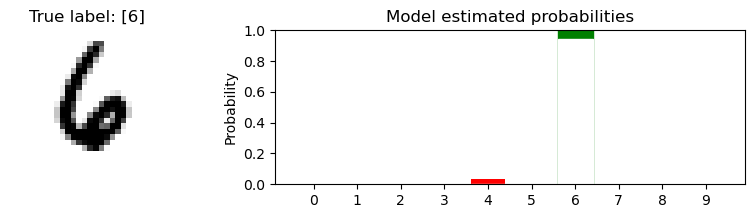

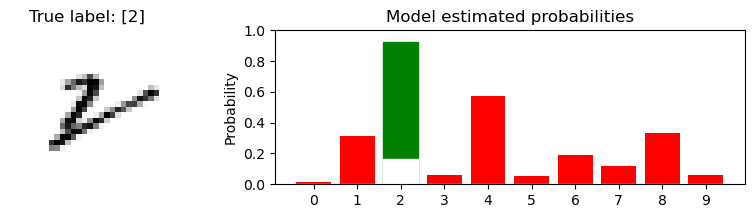

In [40]:
# Prediction examples on MNIST

for i in [0, 1577]:
    analyse_model_prediction(x_test, y_test, bayesian_model, i, run_ensemble=True)

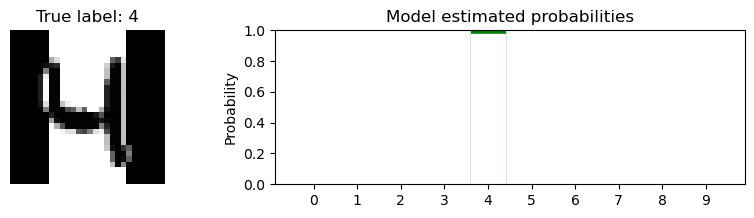

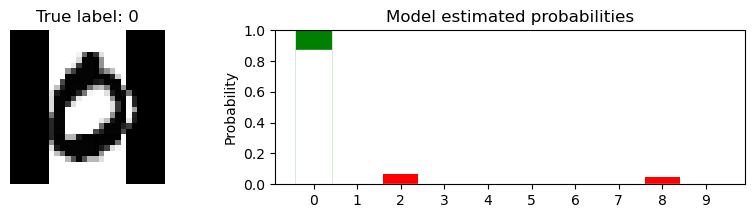

In [47]:
# Prediction examples on MNIST-C

for i in [3500, 3]:
    analyse_model_prediction(x_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

### Uncertainty Quantification Using Entropy

베이지안 신경망 모델에서는 엔트로피를 계산하여 테스트 셋에 대한 모델 예측값들의 불확실성을 측정할 수 있습니다. 예를 들어 $i$번째 샘플의 $j$ 클래스 예측 확률값에 대한 엔트로피는 다음과 같이 계산됩니다.

$$
H_i = - \sum_{j=1}^{10}p_{ij}\mathrm{log}_2(p_{ij})
$$

엔트로피는 측정하는 데 사용되는 로그의 밑에 따라 다른 단위로 측정됩니다.

 * bits: 엔트로피를 계산할 때 밑이 2인 로그를 사용하면 단위는 비트가 됩니다. 비트는 정보 이론에서 흔히 사용되는 단위이며 엔트로피를 측정하는 가장 일반적인 방법입니다.
 * nats: 엔트로피를 계산할 때 자연로그를 사용하면 단위는 nats가 됩니다. nats는 자연로그를 기반으로 하는 정보량의 단위입니다. 1 nat는 약 1.44 bits입니다.

엔트로피의 단위 선택은 개인적인 선호나 상황에 따라 결정됩니다. 비트를 사용하는 경우가 가장 일반적이지만, 경우에 따라서는 자연 로그를 사용하는 편이 계산하기 더 편리한 경우도 있기 때문입니다. 그러나 단위의 선택과는 관계없이 엔트로피 값은 확률 분포의 불확실성을 나타냅니다. 엔트로피가 높을수록 분포가 더 넓게 퍼져 있고, 불확실성이 높다는 것을 의미합니다. 엔트로피가 낮을수록 분포가 더 집중되어 있고, 불확실성이 낮다는 것을 의미합니다.

아래의 함수들은 모델의 예측이 올바른지 여부에 따른 정보 엔트로피의 분포를 시각화하는데 사용됩니다. 함수는 모델이 정확하게 예측한 경우와 부정확한 경우 각각의 정보 엔트로피 분포를 비교하여 모델의 동작을 더 잘 이해할 수 있도록 합니다.

In [44]:
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect


def get_correct_indices(model, x, labels):
    """
    Get indices of correct and incorrect predictions.

    Args:
    - model (tf.keras.Model): The neural network model.
    - x (numpy.ndarray): Input data.
    - labels (numpy.ndarray): True labels.

    Returns:
    Tuple of two lists:
        - List of indices where predictions are correct.
        - List of indices where predictions are incorrect.
    """

    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    """
    Plot the distribution of information entropy for correct and incorrect predictions.

    Args:
    - model (tf.keras.Model): The neural network model.
    - x (numpy.ndarray): Input data.
    - labels (numpy.ndarray): True labels.
    """
        
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

아래는 MNIST 데이터를 예측한 뒤 엔트로피를 계산한 결과입니다. 예측이 틀렸을 때 엔트로피의 값이 더 크고 예측값의 불확실성이 높다는 것을 확인할 수 있습니다.

MNIST test set:


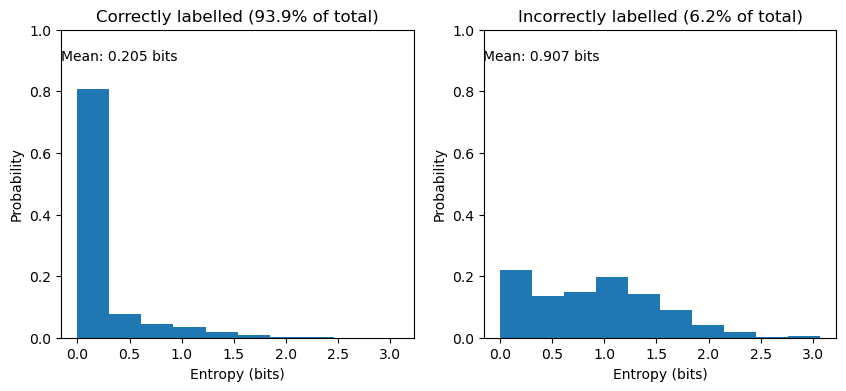

In [45]:
# Entropy plots for the MNIST dataset

print('MNIST test set:')
plot_entropy_distribution(bayesian_model, x_test, y_test)

마찬가지 패턴을 손상된 MNIST 데이터에서도 확인할 수 있습니다.

Corrupted MNIST test set:


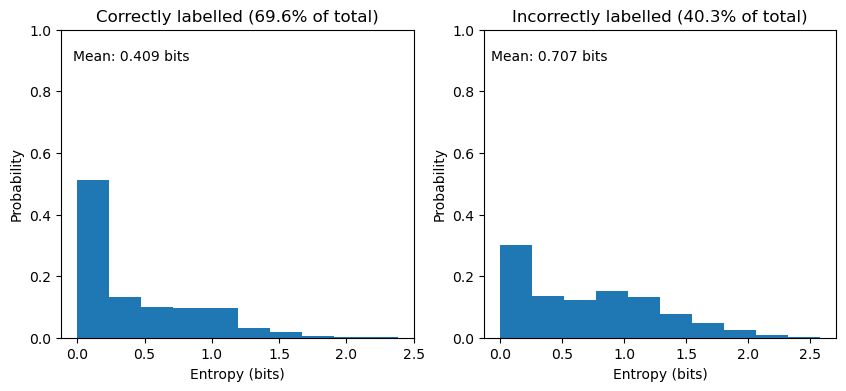

In [46]:
# Entropy plots for the MNIST-C dataset

print('Corrupted MNIST test set:')
plot_entropy_distribution(bayesian_model, x_c_test, y_c_test)